<a href="https://colab.research.google.com/github/Eunvivi/CleanSeoulPM/blob/main/Preprocessing_tow(%EA%B2%AC%EC%9D%B8%EC%8B%A0%EA%B3%A0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ❗️ **전처리 내용** ❗️
1. '주소''컬럼 시/자치구/행정동 분리 후 행정동 추가
2. 행정동 좌표 추가
3. 중복데이터 삭제
4. 유형 전처리
  * 형태소 분리 후 워드클라우드로 빈도 높은 단어 추출
  * 카테고리 지정 후 주차위치, 신고내용 재분류



In [1]:
!pip install koreanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# # row 생략 없이 출력
# pd.set_option('display.max_rows', None)
# # col 생략 없이 출력
# pd.set_option('display.max_columns', None)

# 0️⃣ 파일 로드

In [4]:
data202301 = pd.read_csv('/content/drive/MyDrive/서울시공공데이터 /data/서울특별시_전동킥보드_견인_현황_20230131.csv', encoding ='CP949')
data202301.head(3)

,번호,신고일,구정보,주소,유형,조치일
0,1,2021-07-15,영등포구,서울특별시 영등포구 여의도동 84-10,보도와 차도가 구분된 도로의 차도,2021-07-15
1,2,2021-07-15,영등포구,서울특별시 영등포구 영등포동1가 97-4,보도 중앙,2021-07-15
2,3,2021-07-15,동작구,서울특별시 동작구 노량진동 231-2,보도와 차도가 구분된 도로의 차도,2021-07-15


In [5]:
data202308 = pd.read_csv('/content/drive/MyDrive/서울시공공데이터 /data/서울특별시_전동킥보드_견인_현황_20230831.csv', encoding ='CP949')
data202308.head(3)

,번호,신고일,구정보,주소,유형,조치일
0,1,2021-07-15,영등포구,서울특별시 영등포구 여의도동 84-10,보도와 차도가 구분된 도로의 차도,2021-07-15
1,2,2021-07-15,영등포구,서울특별시 영등포구 영등포동1가 97-4,보도 중앙,2021-07-15
2,3,2021-07-15,동작구,서울특별시 동작구 노량진동 231-2,보도와 차도가 구분된 도로의 차도,2021-07-15


In [6]:
data202312 = pd.read_excel('/content/drive/MyDrive/서울시공공데이터 /data/서울특별시_전동킥보드_견인_현황_20231231.xlsx')
data202312.head(3)

# 0번째 행 컬럼으로
# 첫번째 컬럼 삭제
# 신고일, 조치일 시간제거

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,번호,신고일,구정보,주소,유형,조치일
1,NaN,1,2023-09-01 00:00:00,도봉구,서울특별시 도봉구 쌍문동 482-1,"점자블록, 엘리베이터 입구",2023-09-01 00:00:00
2,NaN,2,2023-09-01 00:00:00,강동구,서울특별시 강동구 성내동 478,"버스정류장, 택시 승강장",2023-09-01 00:00:00


## i) 2023년 12월 데이터 전처리
* 0번째 행 컬럼으로
* 첫번째 컬럼 삭제
* 신고일, 조치일 시간제거

In [7]:
data202312.columns = data202312.iloc[0]
data202312 = data202312.drop(0)
data202312 = data202312.iloc[:, 1:]

In [8]:
# 시간 전처리
data202312['신고일'] = pd.to_datetime(data202312['신고일'])
data202312['조치일'] = pd.to_datetime(data202312['조치일'])

data202312['신고일'] = data202312['신고일'].dt.strftime('%Y-%m-%d')
data202312['조치일'] = data202312['조치일'].dt.strftime('%Y-%m-%d')

In [9]:
data202312.head()

,번호,신고일,구정보,주소,유형,조치일
1,1,2023-09-01,도봉구,서울특별시 도봉구 쌍문동 482-1,"점자블록, 엘리베이터 입구",2023-09-01
2,2,2023-09-01,강동구,서울특별시 강동구 성내동 478,"버스정류장, 택시 승강장",2023-09-01
3,3,2023-09-01,성동구,서울특별시 성동구 성수동2가 277-25,"횡단보도, 산책로 등",2023-09-01
4,4,2023-09-01,강동구,서울특별시 강동구 성내동 478,"버스정류장, 택시 승강장",2023-09-01
5,5,2023-09-01,마포구,서울특별시 마포구 도화동 81,보도와 차도가 구분된 도로의 차도,2023-09-01


## ii) 데이터프레임 병합 및 결측치 확인
* 결측치 2건 확인
* 번호 '2816'으로 중복 및 유형, 조치일 NaN
* 결측치 삭제 조치

In [10]:
# 데이터프레임 병합
data = pd.concat([data202301, data202308, data202312])

# 병합된 데이터프레임의 인덱스 재설정
data.reset_index(drop=True, inplace=True)

In [11]:
data = data.sort_values(by='조치일', ascending=False)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217492 entries, 217491 to 91129
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   번호      217492 non-null  object
 1   신고일     217492 non-null  object
 2   구정보     217492 non-null  object
 3   주소      217492 non-null  object
 4   유형      217490 non-null  object
 5   조치일     217490 non-null  object
dtypes: object(6)
memory usage: 11.6+ MB


In [13]:
# null 데이터만 출력
null_data = data[data.isnull().any(axis=1)]
null_data
# 이상치 데이터 2건 >> 삭제 진행

,번호,신고일,구정보,주소,유형,조치일
2815,2816,2021-08-17,관악구,서울특별시 관악구 신림동 1467-10,NaN,NaN
91129,2816,2021-08-17,관악구,서울특별시 관악구 신림동 1467-10,NaN,NaN


In [14]:
#결측치 데이터 삭제
df = data.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217490 entries, 217491 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   번호      217490 non-null  object
 1   신고일     217490 non-null  object
 2   구정보     217490 non-null  object
 3   주소      217490 non-null  object
 4   유형      217490 non-null  object
 5   조치일     217490 non-null  object
dtypes: object(6)
memory usage: 11.6+ MB


# 1️⃣ 주소 분리
* 서울시, 자치구, 행정동으로 분리
* 행정동 > 동 혹은 가로 끝남 주의
* 서울시, 자치구 제거

In [15]:
import re

In [16]:
# 주소 분리 정규식
def extract_address_parts(address):
    pattern = r"(?P<city>[^ ]+시) (?P<district>[^ ]+구) (?P<town>[^ ]+(동[0-9가]*|동|가|길|로|역)) ?(?P<landmark>산[0-9\-]*)? ?(?P<house_number>[0-9\-]+)?"
    match = re.match(pattern, address)
    if match:
        return (
            match.group('city'),
            match.group('district'),
            match.group('town'),
            match.group('landmark') if match.group('landmark') else "",
            match.group('house_number') if match.group('house_number') else ""
        )
    return None, None, None, None, None

# 새 컬럼 추가
df[['시', '구', '행정동', '지형지물', '번지']] = df['주소'].apply(lambda x: pd.Series(extract_address_parts(x)))

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217490 entries, 217491 to 0
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   번호      217490 non-null  object
 1   신고일     217490 non-null  object
 2   구정보     217490 non-null  object
 3   주소      217490 non-null  object
 4   유형      217490 non-null  object
 5   조치일     217490 non-null  object
 6   시       217487 non-null  object
 7   구       217487 non-null  object
 8   행정동     217487 non-null  object
 9   지형지물    217487 non-null  object
 10  번지      217487 non-null  object
dtypes: object(11)
memory usage: 19.9+ MB


In [18]:
df.head()

,번호,신고일,구정보,주소,유형,조치일,시,구,행정동,지형지물,번지
217491,5451,2023-09-18,마포구,서울특별시 마포구 서교동 343-11,보도와 차도가 구분된 도로의 차도,2023-10-05,서울특별시,마포구,서교동,,343-11
217490,5450,2023-09-27,강남구,서울특별시 강남구 역삼동 801-5,보도 중앙,2023-10-04,서울특별시,강남구,역삼동,,801-5
217377,5337,2023-09-27,송파구,서울특별시 송파구 방이동 222-13,보도와 차도가 구분된 도로의 차도,2023-09-27,서울특별시,송파구,방이동,,222-13
217385,5345,2023-09-27,강북구,서울특별시 강북구 미아동 231,"횡단보도, 산책로 등",2023-09-27,서울특별시,강북구,미아동,,231
217384,5344,2023-09-27,송파구,서울특별시 송파구 석촌동 314,보도와 차도가 구분된 도로의 차도,2023-09-27,서울특별시,송파구,석촌동,,314


In [19]:
df['시'].value_counts()

시
서울특별시    217449
서울시          38
Name: count, dtype: int64

In [20]:
print(df['구'].value_counts())
print('-'*20)
print(df['구정보'].value_counts())

구
마포구     22235
송파구     21188
성동구     18435
강남구     17899
영등포구    17557
서초구     14649
동작구     12122
관악구     11005
동대문구     9202
강서구      8942
용산구      8870
광진구      6968
강동구      6420
중랑구      6169
노원구      5321
도봉구      5205
서대문구     4894
중구       4139
종로구      3555
강북구      3252
성북구      3016
구로구      2976
양천구      2681
은평구       774
금천구        13
Name: count, dtype: int64
--------------------
구정보
마포구     22235
송파구     21186
성동구     18435
강남구     17897
영등포구    17557
서초구     14649
동작구     12123
관악구     11005
동대문구     9204
강서구      8942
용산구      8870
광진구      6968
강동구      6420
중랑구      6169
노원구      5321
도봉구      5205
서대문구     4892
중구       4143
종로구      3555
강북구      3252
성북구      3018
구로구      2976
양천구      2681
은평구       774
금천구        13
Name: count, dtype: int64


In [21]:
df['행정동'].value_counts()

행정동
성수동2가      10602
서초동         9816
봉천동         7993
대치동         6080
여의도동        5621
           ...  
고척로27마길        1
옥인길            1
낙산성곽동길         1
동작대로43길        1
반포대로           1
Name: count, Length: 535, dtype: int64

In [22]:
df['지형지물'].value_counts()

지형지물
            215970
산150-127       159
산25-33          67
산11-1           49
산21-15          45
             ...  
산71-24           1
산296-3           1
산5-40            1
산35-7            1
산36-6            1
Name: count, Length: 306, dtype: int64

In [23]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217487 entries, 217491 to 0
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   번호      217487 non-null  object
 1   신고일     217487 non-null  object
 2   구정보     217487 non-null  object
 3   주소      217487 non-null  object
 4   유형      217487 non-null  object
 5   조치일     217487 non-null  object
 6   시       217487 non-null  object
 7   구       217487 non-null  object
 8   행정동     217487 non-null  object
 9   지형지물    217487 non-null  object
 10  번지      217487 non-null  object
dtypes: object(11)
memory usage: 19.9+ MB


In [24]:
df.head()

,번호,신고일,구정보,주소,유형,조치일,시,구,행정동,지형지물,번지
217491,5451,2023-09-18,마포구,서울특별시 마포구 서교동 343-11,보도와 차도가 구분된 도로의 차도,2023-10-05,서울특별시,마포구,서교동,,343-11
217490,5450,2023-09-27,강남구,서울특별시 강남구 역삼동 801-5,보도 중앙,2023-10-04,서울특별시,강남구,역삼동,,801-5
217377,5337,2023-09-27,송파구,서울특별시 송파구 방이동 222-13,보도와 차도가 구분된 도로의 차도,2023-09-27,서울특별시,송파구,방이동,,222-13
217385,5345,2023-09-27,강북구,서울특별시 강북구 미아동 231,"횡단보도, 산책로 등",2023-09-27,서울특별시,강북구,미아동,,231
217384,5344,2023-09-27,송파구,서울특별시 송파구 석촌동 314,보도와 차도가 구분된 도로의 차도,2023-09-27,서울특별시,송파구,석촌동,,314


In [25]:
#필요한 컬럼만
tow = df[['번호','신고일','조치일','구','행정동','유형']]

In [26]:
#도로명 주소 행정동으로 수정
tow['행정동'] = tow['행정동'].replace({
    '장승배기로': '노량진동',
    '노량진로': '노량진동',
    '사당동139': '사당동',
    '퇴계로': '묵정동',
    '북촌로': '계동',
    '창덕궁3가길': '원서동',
    '상도로60길': '상도동',
    '평창문화로': '평창동',
    '을지로': '을지로2가',
    '계동길': '계동',
    '가락로36길': '방이동',
    '상도로15길': '상도동',
    '왕십리로33길': '하왕십리동',
    '장승배기로13길': '노량진동',
    '마천로': '오금동',
    '사당동1131': '사당동',
    '창덕궁1길': '계동',
    '동호로17길': '신당동',
    '장군봉1길': '봉천동',
    '관악로28길': '봉천동',
    '등용로14길': '대방동',
    '여의대방로22나길': '신대방동',
    '신대방3길': '신대방동',
    '남부순환로': '신림동',
    '청파로': '청파동3가',
    '사당동68': '사당동',
    '백제고분로': '석촌동',
    '사당동205': '사당동',
    '장승배기로27길': '노량진동',
    '중림로8길': '중림동',
    '지봉로13길': '창신동',
    '창덕궁3길': '원서동',
    '새문안로3길': '내수동',
    '상도로': '상도동',
    '지봉로12길': '숭인동',
    '명륜길': '명륜3가',
    '필운대로': '필운동',
    '사당로13길': '사당동',
    '명륜5길': '명륜3가',
    '자양로18길': '구의동',
    '삼청로7길': '팔판동',
    '혜화로16길': '혜화동',
    '돈화문로8길': '묘동',
    '성균관로5길': '명륜3가',
    '삼청로': '삼청동',
    '성균관로': '명륜3가',
    '고척로27마길': '개봉동',
    '사당로': '사당동',
    '사직로': '사직동',
    '평창1길': '평창동',
    '평창길': '평창동',
    '장승배기로10가길': '상도동',
    '낙산성곽서길': '동숭동',
    '등용로': '상도동',
    '대림로': '대림동',
    '새문안로': '신문로2가',
    '반포대로': '반포동',
    '동숭4가길': '동숭동',
    '동작대로43길': '동작동',
    '상도역': '상도1동',
    '옥인길': '누상동',
    '성균관로14길': '명륜1가',
    '낙산성곽동길': '창신동',
    '아차산로': '광장동',
    '동호로': '금호동3가',
    '창경궁로': '원남동',
    '평창20길': '평창동',
    '동망산길': '숭인동',
    '옥인6가길': '누상동',
    '명륜3길': '명륜3가',
    '통일로8길': '송월동',
    '종로1길': '수송동',
    '사직로9길': '사직동',
    '명륜7길': '명륜3가',
    '인사동9길': '인사동',
    '낙산길': '삼선동2가',
    '동순라길': '숭인동',
    '북촌로11다길': '삼청동',
    '대학로': '동숭동',
    '평창11길': '평창동',
    '장문로6길': '동빙고동',
    '종로31길': '연지동',
    '혜화로11길': '혜화동',
    '자하문로19길': '옥인동',
    '필운대로1길': '필운동',
    '노량진로32길': '노량진동'
})

In [27]:
#전처리 완료
tow.head()

,번호,신고일,조치일,구,행정동,유형
217491,5451,2023-09-18,2023-10-05,마포구,서교동,보도와 차도가 구분된 도로의 차도
217490,5450,2023-09-27,2023-10-04,강남구,역삼동,보도 중앙
217377,5337,2023-09-27,2023-09-27,송파구,방이동,보도와 차도가 구분된 도로의 차도
217385,5345,2023-09-27,2023-09-27,강북구,미아동,"횡단보도, 산책로 등"
217384,5344,2023-09-27,2023-09-27,송파구,석촌동,보도와 차도가 구분된 도로의 차도


# 2️⃣ 행정동 좌표 추가

In [28]:
#서울시 행정동 데이터 로드
slo =pd.read_csv('/content/drive/MyDrive/서울시공공데이터 /data/bjd_info_except_boundary.csv', encoding='CP949')

In [29]:
slo.head(3)

,bjd_cd,center_point,center_long,center_lati,bjd_nm,level,sd_cd,sd_nm,sgg_cd,sgg_nm,emd_cd,emd_nm,li_nm,sgg_cnt,emd_cnt,li_cnt,sgg_list,emd_list,li_list
0,1100000000,POINT (126.9918052066339 37.551902938787826),126.991805,37.551903,서울특별시,0,11,서울특별시,11000.0,NaN,11000000,NaN,NaN,25,467,0,['서울특별시 종로구' '서울특별시 중구' '서울특별시 용산구' '서울특별시 성동구...,NaN,NaN
1,1111000000,POINT (126.97732129487213 37.59491731931452),126.977321,37.594917,서울특별시 종로구,1,11,서울특별시,11110.0,종로구,11110000,NaN,NaN,0,87,0,NaN,['서울특별시 종로구 청운동' '서울특별시 종로구 신교동' '서울특별시 종로구 궁정...,NaN
2,1111010100,POINT (126.96932389009248 37.58920545163482),126.969324,37.589205,서울특별시 종로구 청운동,2,11,서울특별시,11110.0,종로구,11110101,청운동,NaN,0,0,0,NaN,NaN,NaN


In [30]:
# '행정동'과 'emd_nm'이 일치하는 행 찾기
merged_tow = pd.merge(tow, slo, how='left', left_on='행정동', right_on='emd_nm')

# 'center_long'와 'center_lati' 컬럼 추가
merged_tow['중심경도'] = merged_tow['center_long']
merged_tow['중심위도'] = merged_tow['center_lati']

# 필요한 컬럼만 선택
merged_tow = merged_tow[['번호', '신고일', '조치일', '구', '행정동', '유형', '중심경도', '중심위도']]

# 컬럼명 한국어로 변경
merged_tow.columns = ['번호', '신고일', '조치일', '구', '행정동', '유형', '중심경도', '중심위도']

In [31]:
merged_tow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335728 entries, 0 to 335727
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   번호      335728 non-null  object 
 1   신고일     335728 non-null  object 
 2   조치일     335728 non-null  object 
 3   구       335728 non-null  object 
 4   행정동     335728 non-null  object 
 5   유형      335728 non-null  object 
 6   중심경도    335728 non-null  float64
 7   중심위도    335728 non-null  float64
dtypes: float64(2), object(6)
memory usage: 20.5+ MB


In [32]:
merged_tow.head()

,번호,신고일,조치일,구,행정동,유형,중심경도,중심위도
0,5451,2023-09-18,2023-10-05,마포구,서교동,보도와 차도가 구분된 도로의 차도,126.918798,37.553839
1,5451,2023-09-18,2023-10-05,마포구,서교동,보도와 차도가 구분된 도로의 차도,127.727299,34.741851
2,5450,2023-09-27,2023-10-04,강남구,역삼동,보도 중앙,127.038549,37.500078
3,5337,2023-09-27,2023-09-27,송파구,방이동,보도와 차도가 구분된 도로의 차도,127.125389,37.515675
4,5345,2023-09-27,2023-09-27,강북구,미아동,"횡단보도, 산책로 등",127.023880,37.621099


# 3️⃣ 중복데이터 삭제

In [33]:
#중복 데이터 확인
dup_tow = merged_tow[merged_tow.duplicated(keep=False)]
dup_tow .info()

<class 'pandas.core.frame.DataFrame'>
Index: 274656 entries, 60881 to 335727
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   번호      274656 non-null  object 
 1   신고일     274656 non-null  object 
 2   조치일     274656 non-null  object 
 3   구       274656 non-null  object 
 4   행정동     274656 non-null  object 
 5   유형      274656 non-null  object 
 6   중심경도    274656 non-null  float64
 7   중심위도    274656 non-null  float64
dtypes: float64(2), object(6)
memory usage: 18.9+ MB


In [34]:
# 중복 데이터 제거 (첫 번째 데이터만 남김)
tow = tow.drop_duplicates(subset='번호', keep='first')

In [35]:
tow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123725 entries, 217491 to 5505
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   번호      123725 non-null  object
 1   신고일     123725 non-null  object
 2   조치일     123725 non-null  object
 3   구       123725 non-null  object
 4   행정동     123725 non-null  object
 5   유형      123725 non-null  object
dtypes: object(6)
memory usage: 6.6+ MB


In [36]:
# 중복데이터 확인
t = tow [tow .duplicated(keep=False)]
t

,번호,신고일,조치일,구,행정동,유형


# 4️⃣ 유형 전처리
* 워드클라우드로 분류할 카데고리 추출

In [37]:
tow.head()

,번호,신고일,조치일,구,행정동,유형
217491,5451,2023-09-18,2023-10-05,마포구,서교동,보도와 차도가 구분된 도로의 차도
217490,5450,2023-09-27,2023-10-04,강남구,역삼동,보도 중앙
217377,5337,2023-09-27,2023-09-27,송파구,방이동,보도와 차도가 구분된 도로의 차도
217385,5345,2023-09-27,2023-09-27,강북구,미아동,"횡단보도, 산책로 등"
217384,5344,2023-09-27,2023-09-27,송파구,석촌동,보도와 차도가 구분된 도로의 차도


In [38]:
# 유형 전처리 목적 새로운 데이터프레임 생성
tow_type = tow[['번호','유형']]

In [39]:
# '유형' 열의 값 빈도 계산 및 데이터프레임으로 변환
type_counts = tow_type['유형'].value_counts().reset_index()
type_counts.columns = ['유형', '빈도']  # 열 이름 변경

In [40]:
type_counts.head()

,유형,빈도
0,보도와 차도가 구분된 도로의 차도,59371
1,"횡단보도, 산책로 등",17363
2,보도 중앙,10152
3,"버스정류장, 택시 승강장",9023
4,자전거 도로,7523


In [41]:
# 데이터 확인
# file_path = '/content/drive/MyDrive/서울시공공데이터 /data/type_counts.xlsx'  # 파일 경로와 이름 수정
# type_counts.to_excel(file_path, index=False)

In [42]:
# '/n' 문자열 삭제
type_counts['유형'] = type_counts['유형'].str.replace('\n', '', regex=True)

In [43]:
#한글 형태소 분리기
!pip install konlpy

In [44]:
text = type_counts['유형']

In [45]:
from konlpy.tag import Kkma, Okt, Komoran, Hannanum
from collections import Counter

# 형태소 분리기
kkma = Kkma()
okt = Okt()
komoran = Komoran()
hannanum = Hannanum()

# 딕셔너리 결과
words = {
    'Kkma': [],
    'Okt': [],
    'Komoran': [],
    'Hannanum': []
}

# 형태소 분석 및 저장
for tool_name, tool in zip(['Kkma', 'Okt', 'Komoran', 'Hannanum'], [kkma, okt, komoran, hannanum]):
    for text in type_counts['유형']:
        morphs = tool.morphs(text)
        words[tool_name].extend(morphs)

# 각 도구별로 형태소의 빈도 계산 및 표시
for tool_name in words:
    freq = Counter(words[tool_name])
    # 데이터프레임 생성
    freq_df = pd.DataFrame(list(freq.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [46]:
# Kkma 데이터프레임화
# kkma 형태소분리기
kkma_words = []
for text in type_counts['유형']:
    morphs = kkma.morphs(text)
    kkma_words.extend(morphs)

# 빈도수 계산
freq = Counter(kkma_words)

# 데이터프레임생성
kkma_freq_df = pd.DataFrame(list(freq.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [47]:
kkma_freq_df

,Word,Frequency
44,주차,430
61,하,336
37,신고,324
46,에,291
36,불편,281
...,...,...
552,브앞,1
551,산,1
548,철,1
547,자하,1


In [48]:
!pip install wordcloud matplotlib
!pip install wordcloud

In [49]:
# 제거할 단어 목록
stopwords = {'하', '에', '어',':','ㅂ니다','킥','세요','-','.','ㅁ','ㄴ','는','#','&',';','가','고','대','ㅇ','[',']','이','음','치우','내','주','위','40','2023-08','기','지','막','40',''}  # 제거하고 싶은 단어

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 지정
font_path = '/content/drive/MyDrive/서울시공공데이터 /data/NanumGothic.ttf'

# 이미 만들어진 데이터 프레임에서 'Word'와 'Frequency'를 추출하여 딕셔너리로 변환
word_freq = dict(zip(kkma_freq_df['Word'], kkma_freq_df['Frequency']))

# 빈도수 20 이상이고 stopwords에 포함되지 않은 단어만 필터링
filtered_word_freq = {word: freq for word, freq in word_freq.items() if freq >= 20 and word not in stopwords}

# 워드클라우드 객체 생성, 한글 폰트 지정
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 경로
    width=400,
    height=400,
    background_color='white'
).generate_from_frequencies(filtered_word_freq)

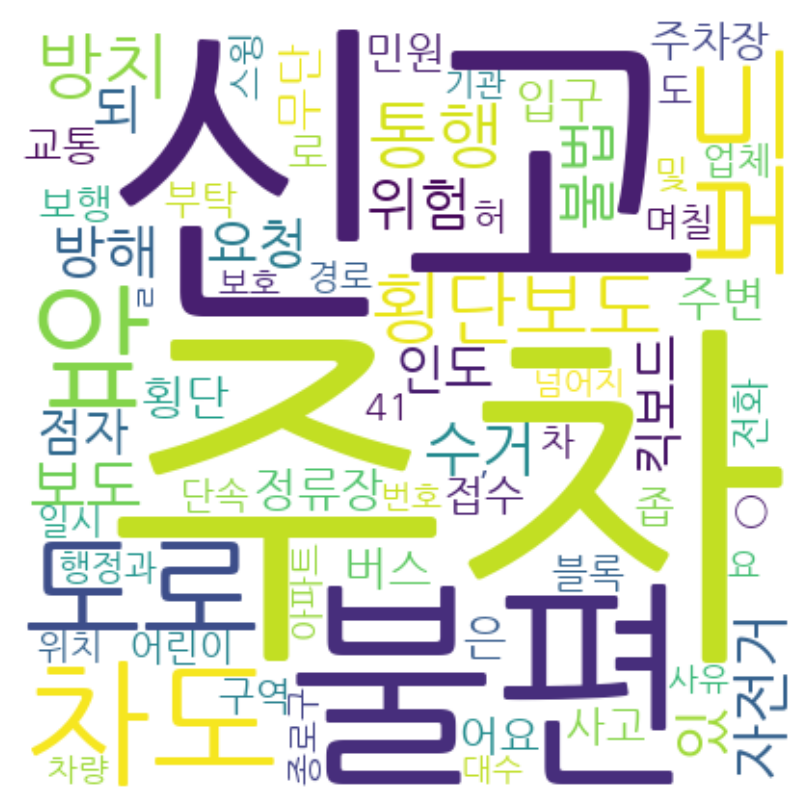

In [51]:
# 워드클라우드 표시
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 제거
plt.show()

* **카테고리 분류**
  * 신고접수 / 주차위치 / 신고이유
    * 신고접수 : 주차위치/ 불편신고
    * 주차위치 : 차도 / 도보 / 이면도로 / 횡단보도 / 자전거도로 / 점자블록 / 어린이보호구역 / 사유지 / 건물앞 / 기타
    * 신고이유 : 통행방해 / 사고위험 / 방치

# 5️⃣ 저장

In [52]:
# tow.to_csv('/content/drive/MyDrive/서울시공공데이터 /data/tow.csv', index=False, encoding='utf-8-sig')